<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/week05_RNN_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sequence Modelling: Text and Audio

In the first part of this week's tutorial, we presented the Recurrent Neural Network (RNN) architecture, where we also discussed the different problems it can help us solve. Now we will use RNNs to tackle text and audio examples. For both data modalities, we will present two problems: classification and generation.

A small recap of both problems is now given.

**Classification**

Classification is a standard problem, where we have some input data $x$ and try to classify it as one of the available classes $y$. In the case of sequential data, though, $x$ will be a sequence of elements that will be processed by the RNN to return the label $y$. The image depicts a sequence classification problem, where the red blocks are inputs, the green blocks the RNN model, and the blue block is the output.

![alt text](https://i.ibb.co/TtZPpZr/Capture.jpg)


**Generation**

In a generation problem, we aim to generate a sequence $y$ following the same distribution as the real data $x$. We will input the sequence into the model, and we will output another sequence $y$.

![](https://i.ibb.co/7gSwnT2/Capture.jpg)



## Preliminary imports

Here we include some of the used imports during the tutorial. Just run it to import the necessary modules.

In [1]:
## These are just a bunch of imports
## Just run them
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten, Add, Lambda
from keras.layers import LSTM, CuDNNLSTM
from keras.datasets import imdb

from keras import __version__
from keras import backend as K


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Keras version:', __version__, 'backend:', K.backend())
K.tensorflow_backend._get_available_gpus()
session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
K.set_session(session)

Using TensorFlow backend.


('Using Keras version:', '2.2.4', 'backend:', u'tensorflow')


# Text 

##Classification

**References:** 

https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/keras-imdb-rnn.ipynb#scrollTo=BYu8ql1nG7xc

For the text classification example we will use the IMDB dataset available in Keras. The dataset includes tens of thousands of movie reviews taken from the IMDB website with a corresponding label for each review. The label is binary, and indicates if the review has a positive or negative sentiment. This problem is a quite standard Natural Language Processing problem, and it is called sentiment classification.

Before loading the data and building our model, we will explain a common part of NLP models, the embeddings.

### Embeddings
**References:** 

[1] https://nlp.stanford.edu/projects/glove/

[2] https://colab.research.google.com/drive/1oXjNYSJ3VsRvAsXN4ClmtsVEgPW_CX_c?hl=en#scrollTo=p9q7qfXrvq-J


Usually, the first step of text modelling is transforming the words into a vector. We will encode the sequences in integer numbers, and we will also have a dictionary that contains the relationship `(actual word, integer)`. For example, the sentence "the cat is on the table and the dog is on the mat" can be encoded in the form $(7, 1, 3, 5, 7, 6, 0, 7, 2, 3, 5, 7, 4)$, with the corresponding dictionary $(and, 0), (cat, 1), (dog, 2)\dots (the, 7)$. In a code form, the representation is done like this:

In [2]:
sentence = 'the cat is on the table and the dog is on the mat'
## We form a list of unique words by using a set
## which returns only unique elements
## we also sort them, which is not necessary
sentence_set = sorted(set(sentence.split(' ')))
words = list(sentence_set)
## We now form a dictionary in the form of 
## e.g. dict_words[and] = 1
dict_words = dict((word, i) for i, word in enumerate(words))
## We now encode the sentence in a list of integers
encoded_sentence = [dict_words[w] for w in sentence.split()]
print(sentence_set)
print(encoded_sentence)
print(dict_words)

['and', 'cat', 'dog', 'is', 'mat', 'on', 'table', 'the']
[7, 1, 3, 5, 7, 6, 0, 7, 2, 3, 5, 7, 4]
{'and': 0, 'on': 5, 'mat': 4, 'is': 3, 'dog': 2, 'cat': 1, 'table': 6, 'the': 7}


Keras contains a class called `Tokenizer` that helps in performing this process. We will not use it for the examples in this tutorial, as we want to show all the steps involved in the tokenization process, but the `Tokenizer` class provides a high-level way to handle this preprocessing step. As it can be quite useful, we provide a small overview of it. [Here](https://keras.io/preprocessing/text/) you have a link to the Keras documentation explaining the different arguments of the class.

In [0]:
import keras
## First you define a tokenizer object
## If you want a character level tokenization we set char_level=True
## If set to false, it will tokenize in a word level
## You can check in the documentation the different arguments
tokenizer = keras.preprocessing.text.Tokenizer(char_level=False)
## Then you fit it on the data you have
## The method expects a list of sentences
tokenizer.fit_on_texts([sentence])


In [4]:
## Now, the class has formed a dictionary with all the words
print(tokenizer.word_index)


{'and': 6, 'on': 3, 'mat': 8, 'is': 2, 'dog': 7, 'cat': 4, 'table': 5, 'the': 1}


In [5]:
## You can also check the word count
print(tokenizer.word_counts)

OrderedDict([('the', 4), ('cat', 1), ('is', 2), ('on', 2), ('table', 1), ('and', 1), ('dog', 1), ('mat', 1)])


In [6]:
## You can transform the data to sequences of integers
## We print the first 10 elements
tokenizer.texts_to_sequences([sentence])

[[1, 4, 2, 3, 1, 5, 6, 1, 7, 2, 3, 1, 8]]

Now that we have the sequence in the form of a list of integers,  we could input that directly to the RNN. However, it would be really hard for the RNN to understand the relationships between the words. To give the model more representation power, we first want to transform the integer to a vector of dimension $d$ which represents the semantic meaning of the words. Each of these vectors is called an Embedding. The actual values of the vectors are not important, only the relationships between them. For example, `dog` and `cat` vectors are probably going to be closer than `dog` and `the`.

 The embeddings can be initialized randomly and the model will learn suitable values to reduce the loss during the training process. However, embeddings which have already been trained in a large corpus of text such as Wikipedia can also be used. Examples of these pretrained embeddings are [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) or  [GloVe](https://nlp.stanford.edu/projects/glove/). These methods are trained using the context, for example predicting the context when an specific word is given. As a result, words that appear in similar contexts have closer embeddings.

![alt text](https://i.ibb.co/s5sg6dZ/Screenshot-from-2019-02-08-15-13-41.png) 

The image shows relationships between words in the embedding space.



We now download the GloVe pretrained vectors trained in Wikipedia and Gigaword. [Here](https://nlp.stanford.edu/projects/glove/) you have an overview of what GloVe is. We will see how the embeddings contain a semantic meaning that allows us to model semantic relationships. The time it takes to download the embeddings may vary, it should be between 1 to 3 minutes.

In [0]:
## Donwload and unzip glove pretrained embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!apt-get -qq install unzip
!unzip glove.6B.zip

We will now load the GloVe embeddings. We use gensim to manipulate the embeddings, which is a nice tool that can be used to play with GloVe or Word2Vec embeddings. This piece of code also takes some time to load, as the embeddings file is quite large.

In [0]:
## We load the embeddings
## Gensim is a really useful module that provides high-level function
## to use with the embeddings
!pip install gensim
from gensim.models import word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
## These next three lines just load the embeddings into the object glove_model
glove2word2vec(glove_input_file="glove.6B.300d.txt", word2vec_output_file="gensim_glove_vectors.txt")
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

Now we will do some operations using the embeddings of the words. First, we will do some words arithmetics based on the embeddings so you can see how they contain some meaning. For example, the distance between words with similar semantic meaning but different genders is kind of constant. Meaning that the vector resulting from doing $man - woman$ should be similar to $king - queen$, hence:

$king - queen \approx man - woman \rightarrow woman + king - man \approx queen$

We can check this using the method `most_similar` and the `positive` and `negative` arguments as following:



In [61]:
## We can do word arithmetics. 
## We look for the nearest neighbour of the vector resulting on doing
## the operation 'king' + 'woman' - 'man'
glove_model.most_similar(positive=['woman', 'king'], negative=['man'])

[(u'queen', 0.6713277101516724),
 (u'princess', 0.5432624220848083),
 (u'throne', 0.5386104583740234),
 (u'monarch', 0.5347574949264526),
 (u'daughter', 0.498025119304657),
 (u'mother', 0.4956442713737488),
 (u'elizabeth', 0.4832652509212494),
 (u'kingdom', 0.47747087478637695),
 (u'prince', 0.4668239951133728),
 (u'wife', 0.4647327661514282)]

In [10]:
## Similar examples
glove_model.most_similar(positive=['google', 'ios'], negative=['apple'])

[(u'android', 0.5720318555831909),
 (u'apps', 0.5662358999252319),
 (u'app', 0.5322650671005249),
 (u'facebook', 0.4770544171333313),
 (u'smartphones', 0.47069066762924194),
 (u'gmail', 0.4677259922027588),
 (u'firefox', 0.4666402041912079),
 (u'skype', 0.4491073191165924),
 (u'iphone', 0.44582629203796387),
 (u'web-based', 0.44464385509490967)]

In [11]:
glove_model.most_similar(positive=['england', 'paris'], negative=['france'])

[(u'london', 0.6710129976272583),
 (u'manchester', 0.5267472863197327),
 (u'birmingham', 0.49347949028015137),
 (u'liverpool', 0.49033817648887634),
 (u'oxford', 0.4811282157897949),
 (u'middlesex', 0.47516536712646484),
 (u'surrey', 0.46148526668548584),
 (u'sussex', 0.45899876952171326),
 (u'leeds', 0.4551934599876404),
 (u'essex', 0.45398280024528503)]

In [12]:
## We can also check the word that does not match the rest
glove_model.doesnt_match("breakfast cereal dinner lunch".split())

'cereal'

To check out other functions you can call use [this](https://radimrehurek.com/gensim/models/keyedvectors.html#module-gensim.models.keyedvectors).


In http://projector.tensorflow.org/ you can visualize the words projected in the $\mathbb{R}^3$ space using either PCA or tSNE, which are both techniques for dimensionality reduction. There, you can see how words are clustered by meaning or topic.


![](https://brenndoerfer.github.io/deep-sentiment-analysis-distill/img/tensorboard_projector.gif)

Image taken from [here](https://brenndoerfer.github.io/deep-sentiment-analysis-distill/index.html)

### IMDB
Now let's start with the text classification problem. We first load the IMDB dataset for sentiment classification. As we said, it contains movie reviews with a corresponding binary sentiment label. The words are already encoded as integers in order from most common words to less common (e.g. `the` is a common word so it should be encoded as a small integer). That makes it easy to filter the non-common words by using the argument `num_words` when loading the data. The filtered words will be all encoded as a special token `<UNK>`, which means unknown. For example, if we want to load the dataset with only the top $20000$ most common words we can do this:

In [13]:
# number of most-frequent words to use
nb_words = 20000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

Loading data...
17473536/17464789 [==============================] - 2s 0us/step
('x_train:', (25000,))
('x_test:', (25000,))


We see that the dataset contains 25000 examples for both train and testing. Let's print an example.

In [14]:
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


The printed example is a sequence of numbers. It is important to note that there are three special integers in this IMDB dataset: $0$, $1$ and $2$. $0$ will be used to pad the sequences, which we will explain now. $1$ is used as the `<START>` token (you can see how the printed sequence starts with a `1`). $2$ is the token `<UNK>` which is used for all the filtered non-common words. If we want to retrieve the actual sentence, we can use the dictionary given when using the method `get_word_index()`. However, the given dictionary when calling `get_word_index()` does not take into account the three mentioned tokens, so we need to modify it a little bit.

In [15]:
# get_word_index retrieves a mapping word -> index
word_index = imdb.get_word_index()
# We make space for the three special tokens
word_index_c = dict((w, i+3) for (w, i) in word_index.items())
word_index_c['<PAD>'] = 0
word_index_c['<START>'] = 1
word_index_c['<UNK>'] = 2
# Instead of having dictionary word -> index we form
# the dictionary index -> word
index_word = dict((i, w) for (w, i) in word_index_c.items())
# We now retrieve the sentence
sentence = ''
for index in x_train[0]:
  sentence += index_word[index] + ' '
print(sentence)

1654784/1641221 [==============================] - 1s 1us/step
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile fo

We can see how we just recovered the sentence that we had printed before as a sequence of numbers. We can also see how there is no punctuation in this dataset.

One of the problems with the given text data is that the sequences all have a different length. We want to give Keras a batch of inputs with fixed dimensions. To do so, we define a maximum length `maxlen`, and truncate the sentences longer than that, and also pad with $0$'s at the beginning the sentences shorter than that length. We use the method `sequence.pad_sequence` from `keras.preprocessing`

In [16]:
# Truncate sentences after this number of words
maxlen = 80
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
('x_train shape:', (25000, 80))
('x_test shape:', (25000, 80))


We can check how some sentences are padded at the beginning to be of length `maxlen`.

In [17]:
x_train[5]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     1,   778,   128,    74,    12,   630,   163,    15,
           4,  1766,  7982,  1051,     2,    32,    85,   156,    45,
          40,   148,   139,   121,   664,   665,    10,    10,  1361,
         173,     4,   749,     2,    16,  3804,     8,     4,   226,
          65,    12,    43,   127,    24, 15344,    10,    10],
      dtype=int32)

We now build the model we will use for sentiment classification. The model is formed by an Embedding layer, where the model will learn a vector of dimensionality `embedding_dim` for each of the words; a LSTM layer and a linear layer that maps the output of the LSTM to 1 value. We use CuDNNLSTM instead of LSTM, which is just a faster implementation of LSTM when using GPU, as in our case. We train this with the `binary_crossentropy` loss and `sigmoid` activation as we only have two classes. 

In [18]:
## Model parameters:
# Dimensions of the embeddings
embedding_dim = 300
## LSTM dimensionality
lstm_units = 128

print('Build model...')
text_class_model = Sequential()

text_class_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen))

# model.add(LSTM(lstm_units))
# CuDNNLSTM is a faster implementation of LSTM if running on a GPU:
text_class_model.add(CuDNNLSTM(lstm_units))

# To stack multiple RNN layers, all RNN layers except the last one need
# to have "return_sequences=True".  An example of using two RNN layers:
# model.add(CuDNNLSTM(lstm_units, return_sequences=True))
# model.add(CuDNNLSTM(lstm_units))


# You can add some dropout if you want
# model.add(Dropout(0.5))

text_class_model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
text_class_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(text_class_model.summary())

Build model...
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 300)           6000000   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 128)               220160    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 6,220,289
Trainable params: 6,220,289
Non-trainable params: 0
_________________________________________________________________
None


Let's train it for 5 epochs.

In [19]:
## We train the model for 5 epochs and check the accuracy in a validation split
epochs = 5
validation_split = 0.2

history = text_class_model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, validation_split=validation_split)


Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 9s 446us/step - loss: 0.4460 - acc: 0.7823 - val_loss: 0.3903 - val_acc: 0.8218
Epoch 2/5
20000/20000 [==============================] - 5s 249us/step - loss: 0.2464 - acc: 0.9038 - val_loss: 0.3963 - val_acc: 0.8396
Epoch 3/5
20000/20000 [==============================] - 5s 247us/step - loss: 0.1413 - acc: 0.9488 - val_loss: 0.5080 - val_acc: 0.8224
Epoch 4/5
20000/20000 [==============================] - 5s 250us/step - loss: 0.0802 - acc: 0.9723 - val_loss: 0.5649 - val_acc: 0.8206
Epoch 5/5
20000/20000 [==============================] - 5s 249us/step - loss: 0.0585 - acc: 0.9796 - val_loss: 0.7041 - val_acc: 0.8156


This is a classification example, so let's print the loss and the classification accuracy.

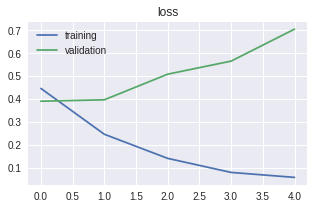

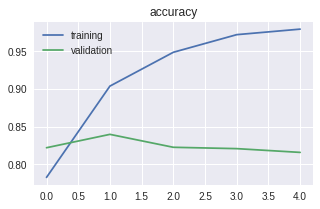

In [20]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'], label='training')
plt.plot(history.epoch,history.history['val_acc'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

It looks like we could have stopped the training in the first epoch as the validation loss did not decrease afterwards.

In [21]:
# Let's see the accuracy in the test split
scores = text_class_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (text_class_model.metrics_names[1], scores[1]*100))

acc: 81.16%


### Saving best performing model

Now we are going to give a practical example of how saving the best performing models using the validation loss as a metric. As you already know, lower training error does not mean in some cases better performance in the validation or test split.

In the last example we ran the model for 5 epochs, however after the first epoch the validation loss increased. We want to use the model performing the best in the validation set. To do so, we can use a ModelCheckpoint callback.

In [22]:
###### We reset the model #######
text_class_model = Sequential()
text_class_model.add(Embedding(nb_words,
                    embedding_dim,
                    input_length=maxlen))
text_class_model.add(CuDNNLSTM(lstm_units))
text_class_model.add(Dense(1, activation='sigmoid'))
text_class_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#################################


from keras.callbacks import ModelCheckpoint
## Here we define the checkpoint callback. We first give the name it will use 
## to save the model. We also specify what metric should monitor, in this case
## the validation loss (it could be validation accuracy too for example)
## save_best_only means that the models will only be save when the monitored 
## metric improves with respect to the past best one
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5', verbose=1, 
                             monitor='val_loss',save_best_only=True)  
## Now we pass the callback to the fit method
history = text_class_model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, callbacks=[checkpoint],
          validation_split=validation_split)



Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 7s 337us/step - loss: 0.4606 - acc: 0.7747 - val_loss: 0.3662 - val_acc: 0.8394

Epoch 00001: val_loss improved from inf to 0.36616, saving model to model-001.h5
Epoch 2/5
20000/20000 [==============================] - 5s 249us/step - loss: 0.2488 - acc: 0.9018 - val_loss: 0.3968 - val_acc: 0.8430

Epoch 00002: val_loss did not improve from 0.36616
Epoch 3/5
20000/20000 [==============================] - 5s 249us/step - loss: 0.1397 - acc: 0.9489 - val_loss: 0.5217 - val_acc: 0.8230

Epoch 00003: val_loss did not improve from 0.36616
Epoch 4/5
20000/20000 [==============================] - 5s 249us/step - loss: 0.0814 - acc: 0.9721 - val_loss: 0.6186 - val_acc: 0.8234

Epoch 00004: val_loss did not improve from 0.36616
Epoch 5/5
20000/20000 [==============================] - 5s 248us/step - loss: 0.0454 - acc: 0.9849 - val_loss: 0.6852 - val_acc: 0.8096

Epoch 00005: val_loss did n

We now saved the model after every epoch if the validation loss decreased. In this case, as the best epoch is the first one, it only saves the model after the first epoch. Let's load the model now.

In [0]:
from keras.models import load_model
text_class_model = load_model('model-001.h5')  # load model weights

And now we check if the accuracy is better compared to when we used the model trained the model for 5 epochs.

In [24]:
# Let's see the accuracy in the test split
scores = text_class_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (text_class_model.metrics_names[1], scores[1]*100))

acc: 84.09%


As we can see, the accuracy is slightly better! 

### Importance of embeddings
Now, let's check quickly if using Embeddings provide any benefit. For this experiment, we remove the Embedding layer, and also vary the shape of the input data as the LSTM needs a third dimension with the number of channels per input (in this case 1, as each word is represented by only a number).

In [25]:
# model parameters
# Same model as before but without embeddings
lstm_units = 128
x_train_r = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test_r = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


print('Build model...')
text_class_model = Sequential()

text_class_model.add(CuDNNLSTM(lstm_units, input_shape=(maxlen, 1)))

text_class_model.add(Dense(1, activation='sigmoid'))

text_class_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(text_class_model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 128)               67072     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 67,201
Trainable params: 67,201
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
epochs = 5
validation_split = 0.2

history = text_class_model.fit(x_train_r, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 5s 256us/step - loss: 0.6917 - acc: 0.5242 - val_loss: 0.6850 - val_acc: 0.5570
Epoch 2/5
20000/20000 [==============================] - 3s 162us/step - loss: 0.6859 - acc: 0.5472 - val_loss: 0.6806 - val_acc: 0.5706
Epoch 3/5
20000/20000 [==============================] - 3s 163us/step - loss: 0.6859 - acc: 0.5477 - val_loss: 0.6851 - val_acc: 0.5544
Epoch 4/5
20000/20000 [==============================] - 3s 163us/step - loss: 0.6854 - acc: 0.5522 - val_loss: 0.6834 - val_acc: 0.5656
Epoch 5/5
20000/20000 [==============================] - 3s 161us/step - loss: 0.6853 - acc: 0.5518 - val_loss: 0.6876 - val_acc: 0.5494


In [27]:
scores = text_class_model.evaluate(x_test_r, y_test, verbose=2)
print("%s: %.2f%%" % (text_class_model.metrics_names[1], scores[1]*100))

acc: 53.73%


We see how the accuracy is just slightly better compared to doing a random guess as there are only 2 classes. Hence, using embeddings results in models with better capacity/accuracy for this kind of tasks.

Instead of inputting directly integers to the RNN, we could argue that another way of representing the input words is to input the one-hot representation of the word directly to the RNN instead of using embeddings. This method has two problems. First, the resulting dimensionality would be too large. In this case we are loading the $20000$ most common words in IMDB, so each word would be encoded in a vector of dimensionality $20000$. Secondly, the encoding does not give any notion of similarity between the different words. For these two reasons, embedding the words to a common lower dimensionality space is also better than using one-hot encoding.

## Generation

We now will use the recurrent neural networks to generate new text samples. For this example, we will use the Tiny Shakespeare dataset, which contains samples from Shakespeare works.

We pose the problem as a classification problem as in the Sentiment classification example. In a text generation setting, given a sequence, we aim to predict the next one. During the training step, the process would be quite similar to the classification task, i.e. given a sequence you predict a label/word/character. However, in the prediction setting, we aim to output a whole sentence, not only a word or character. For that reason we will follow the procedure explained in the image.

![](https://cdn-images-1.medium.com/max/1600/1*XvUt5wDQA8D3C0wAuxAvbA.png)
The image is taken from [here](https://medium.com/@david.campion/text-generation-using-bidirectional-lstm-and-doc2vec-models-1-3-8979eb65cb3a)

As in the classification section, we encode the raw sentences in the form of a sequence of integers. In this case, however, we have a text with a really wide vocabulary, and we aim to predict the following element of the sequence. In this dataset the number of words is really large, so if we used a word-level model the number of available classes would be quite large. For this reason, instead of encoding on a word level, we will do it on a character level, which results in a more limited vocabulary. We aim to predict the next character when inputting a sentence of length $d$. In evaluation mode, i.e. when we are predicting the next character, we then input a seed of $d$ characters as the first input, and afterwards we use the last $d$ characters as input to predict the next character. 

The advantages of predicting characters instead of words is that character level models have a limited vocabulary/classes compared to the number of possible words in a text. However, word level models usually present higher performance as it easier for them to keep track of the long-term meaning of the sentence.

**References:** Some code snippets taken from [here](https://www.analyticsvidhya.com/blog/2018/03/text-generation-using-python-nlp/)


We first download the data we use for the example, and then read the file. 

In [27]:
!wget https://raw.githubusercontent.com/jcjohnson/torch-rnn/master/data/tiny-shakespeare.txt
## We read all the raw data in the variable data
data = open('./tiny-shakespeare.txt', 'r').read()

--2019-02-08 14:37:19--  https://raw.githubusercontent.com/jcjohnson/torch-rnn/master/data/tiny-shakespeare.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘tiny-shakespeare.txt’

tiny-shakespeare.tx 100%[===================>]   1.06M  --.-KB/s    in 0.07s   

2019-02-08 14:37:19 (14.4 MB/s) - ‘tiny-shakespeare.txt’ saved [1115394/1115394]



Let's print a subset of the data for visualization purposes.

In [28]:
print(data[:364])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?


We see in the raw text that the name of the characters is printed, that there is a blank line between the different character lines, and that lines are usually not longer than ~80 characters. We hope the network is capable of learning all of this.

Now we put the data in a more structured way. We aim to encode the text using a sequence of integers as we explained in the classification section.  Hence, we form a dictionary with all the different characters appearing in the text (including whitespaces and punctuation) and its corresponding integer. 

In [0]:
characters = sorted(list(set(data)))
n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}

Now w want to split the text in examples of length `seq_length` where the label is the next character. To do so, we use the dictionary `char_to_n` to encode the different elements as a sequence of integers.


In [30]:
x = []
y = []
length = len(data)
seq_length = 100
for i in range(0, length-seq_length, 1):
  sequence = data[i:i + seq_length]
  label = data[i + seq_length]
  x.append([char_to_n[char] for char in sequence])
  y.append(char_to_n[label])
n_samples = len(x)
print "Total Samples: ", n_samples

Total Samples:  1115294


We now form a test split by using 5% of the available data. To do so, we just take the last 5% of the data. Usually, you need to randomize the data before splitting in test/train to avoid having different distribution of the data in both splits. However, as this is a sequential data where we want to predict the next character, if we shuffle the splits we would have e.g. this in training:

``
x = 'the boy is tal_' y = 'l'
``

and this in testing:

``
x = 'the boy is ta_' y = 'l'
``

which would contaminate the splits.

In [0]:
import keras
x_train = x[:int(n_samples*0.95)]
x_test = x[int(n_samples*0.95):]
y_train = y[:int(n_samples*0.95)]
y_test = y[int(n_samples*0.95):]

## Transform the list to a numpy array
x_train = np.reshape(x_train, (len(x_train), seq_length))
## Onehot encoding of labels
y_train = keras.utils.to_categorical(np.asarray(y_train))

x_test = np.reshape(x_test, (len(x_test), seq_length))
y_test = keras.utils.to_categorical(np.asarray(y_test))


Let's print a sequence and the shape of the labels.

In [32]:
print(x_train[8000])
print(y_train.shape)

[ 0 13  1 57 47 41 49  1 51 39 52  5 57  1 39 54 54 43 58 47 58 43  6  1
 61 46 53  1 42 43 57 47 56 43 57  1 51 53 57 58  1 58 46 39 58  0 35 46
 47 41 46  1 61 53 59 50 42  1 47 52 41 56 43 39 57 43  1 46 47 57  1 43
 60 47 50  8  1 20 43  1 58 46 39 58  1 42 43 54 43 52 42 57  0 33 54 53
 52  1 63 53]
(1059529, 65)


Here, we define the model. As we want to give it a little bit more of capacity to our model, we use two different LSTM stacked on top of each other. To do so, we need to use the `return_sequences=True` in the first of the two LSTM. If you want to know a little bit more about the `return_sequences` argument, you can check [this reference](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/).

In [34]:
# define the LSTM model
embedding_size = 300
lstm_units = 256

text_gen_model = Sequential()
text_gen_model.add(Embedding(y_train.shape[1],
                    embedding_size, input_length=seq_length))
text_gen_model.add(CuDNNLSTM(lstm_units, return_sequences=True))
text_gen_model.add(Dropout(0.2))
text_gen_model.add(CuDNNLSTM(lstm_units))
text_gen_model.add(Dropout(0.2))
text_gen_model.add(Dense(y_train.shape[1], activation='softmax'))

text_gen_model.compile(loss='categorical_crossentropy', optimizer='adam')
text_gen_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          19500     
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 100, 256)          571392    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 256)               526336    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 65)                16705     
Total params: 1,133,933
Trainable params: 1,133,933
Non-trainable params: 0
_________________________________________________________________


To obtain good results, we need to train for a long time. For this reason, we also provide some weights that you can load for a model trained with this architecture and data. 

In [0]:
text_gen_model.fit(x_train, y_train, epochs=10 , batch_size=128)

If you want to download a pretrained model, run the following cell.

In [36]:
!wget https://transfer.sh/pnruR/text_generation.h5
from keras.models import load_model
text_gen_model = load_model('text_generation.h5')

--2019-02-08 14:47:24--  https://transfer.sh/pnruR/text_generation.h5
Resolving transfer.sh (transfer.sh)... 144.76.136.153
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13644376 (13M) [application/octet-stream]
Saving to: ‘text_generation.h5’

text_generation.h5  100%[===================>]  13.01M  4.44MB/s    in 2.9s    

2019-02-08 14:47:49 (4.44 MB/s) - ‘text_generation.h5’ saved [13644376/13644376]



### Prediction

We now take any of the sequences from the test split and use it as an initial seed. Then we enter a loop where given an input sequence, we predict the next character and then form a new input sequence by appending the predicted character and dropping the first character.

Whenever we input a sequence, we obtain as output a probability distribution of the possible characters. For example, given the sequence `the cat and the do` the model will output a probability distribution of the next character where probably the character `g` will have a high probability (forming then `the cat and the dog`). However, the character `c` can also be a possibility, as the sentence formed may be `the cat and the doctor`. When deciding what character to predict, a strategy is to just take the character with the maximum probability at all times. However, the variability of the formed text is then smaller. Another option would be to sample following the same probability of distribution as the model outputs. However, this might result in a large variability with some sentences not making any sense.

This trade-off of variability against more probable sequences is controlled by what it is called the temperature of the sampling process. The temperature controls the smoothing on the probability vector. A temperature close to 0 will result in taking always the safest (i.e. that with the highest probability) as the next element. A temperature close to 1 will decide on the next element following the same distribution of probability as the original output of the model.

In a more formal way, being $p_i$ the probability of the element $i$ output by the RNN model and $T$ the temperature, the  the probability after applying the mentioned smoothing $\hat{p_i}$ is:

$$
\hat{p_i} = \frac{e^{\log(p_i)/T}}{\sum_j e^{\log(p_j)/T}}
$$

You can check how a small $T$ is going to make the element with the largest probability be close to 1 after the process.

Before starting the text prediction, let's show an example of how the sampling temperature affects the model choices.

In [37]:
def temperature_smoothing(prediction, temperature=1.0):
  # This function computes the temperature smoothing function
  # we explained
  prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
  exp_preds = np.exp(prediction)
  prediction = exp_preds / np.sum(exp_preds)
  return prediction

# We have this vector of probabilities
prediction = np.asarray([0.2, 0.3, 0.1, 0.4])
## Temperature = 1.0
print('Output probabilities with temp.=1')
print(temperature_smoothing(prediction, temperature=1))
## Temperature = 0.5
print('Output probabilities with temp.=0.5')
print(temperature_smoothing(prediction, temperature=0.5))
## Temperature = 0.25
print('Output probabilities with temp.=0.25')
print(temperature_smoothing(prediction, temperature=0.25))
## Temperature = 0.0
print('Output probabilities with temp.=0')
print(temperature_smoothing(prediction, temperature=0))

Output probabilities with temp.=1
[0.20065194 0.29977201 0.10101691 0.39855913]
Output probabilities with temp.=0.5
[0.13579339 0.30071527 0.03488383 0.5286075 ]
Output probabilities with temp.=0.25
[0.04948661 0.23537565 0.00344097 0.71169677]
Output probabilities with temp.=0
[7.88880627e-31 3.20722891e-13 6.22348202e-61 1.00000000e+00]


You can see how a lower temperature makes the small probabilities become smaller and the biggest probability become bigger.

Here you can set the temperature and check how the output varies. You will see that for $T\approx0$ the generated text is pattern like, with low variability.

In [38]:
import sys
# Vary the temperature here
temperature = 0.5

# We select a random element from the test set as seed
start = np.random.randint(0, len(x_test)-1)
pattern = x_test[start].tolist()
print "Seed:"
print "\"", ''.join([n_to_char[value] for value in pattern]), "\""

print("\nPredicted:")
# generate 300 characters
for i in range(300):
  x = np.reshape(pattern, (1, len(pattern)))
  prediction = text_gen_model.predict(x, verbose=0).astype(np.float64)
  ## We put the constant 0.02 to avoid dividing by zero
  ## We sum by 1e-7 to avoid log(0)
  prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
  exp_preds = np.exp(prediction)
  prediction = exp_preds / np.sum(exp_preds)
  ## We applied the smoothing with the temperature
  ## Now we predict following the probabilities in the variable prediction
  prediction = np.random.multinomial(1, prediction[0,:], 1)
  index = np.argmax(prediction)
  result = n_to_char[index]
  seq_in = [n_to_char[value] for value in pattern]
  ## Print the result
  sys.stdout.write(result)
  
  ## Create the input sequence for the next character by appending the predicted
  ## character and dropping the first one to always have constant seq. length
  pattern.append(index)
  pattern = pattern[1:]


Seed:
"  at least is banish'd from your eye,
Who hath cause to wet the grief on't.

ALONSO:
Prithee, peace.
"

Predicted:

HENRY BOLINGBROKE:
I see him for my father, and here thou art a part.

KING RICHARD II:
Why what I have to come to make the more.

GLOUCESTER:
Now, sir, you have good and stone, and many the self,
And bring the banish'd but the golden prove!

KING RICHARD II:
What saying him, and my head, I am my u

Notice how the network has learnt the structure of the text, to start a new line every few words and to put the name of the characters too. The text itself seems grammatically correct but fails to make much sense in most examples. Test different temperature settings to see how it affects the generation

If you want to know more about text generation, along with some extra generated examples, we refer you to [Andrej Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

### Quantitative evaluation of generated text

In past tutorials, we explained some of the metrics used for text evaluation. In this case we will use one of them, BLEU, to give a quantitative score to the generated text. BLEU looks for matches on a word level between the generated text and the reference text. Specifically, BLEU looks for matches in n-grams up to $n=4$, where an n-gram is defined as a contiguous sentence of $n$ items. For example, in the sentence `the sky is blue`, an n-gram of $n=2$ would be `is blue`. 

There is a large number of both grammatically and semantically correct possibilities when generating new sentences, but we hope to see a correlation between the BLEU score and the quality of the generated text. Here we just take different seeds from the test data, and compared the generated sentence to the real one from the corpus. We do so 20 times and provide the average BLEU score.

The used function is integrated in the package `nltk` and it is called using the following syntax `sentence_bleu(reference, candidate).`

In [39]:
from nltk.translate.bleu_score import sentence_bleu
import sys
temperature = 0.0
bleu_score = 0
n_eval = 20
for _ in range(n_eval):
  start = np.random.randint(0, len(x_test)-len(pattern)-1)
  pattern = x_test[start].tolist()
  reference = x_test[start+len(pattern)].tolist()
  reference = ''.join([n_to_char[value] for value in reference]).split(' ')
  # generate characters
  output_sent = ''
  for i in range(100):
    x = np.reshape(pattern, (1, len(pattern)))
    prediction = text_gen_model.predict(x, verbose=0).astype(np.float64)
    prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
    exp_preds = np.exp(prediction)
    prediction = exp_preds / np.sum(exp_preds)
    prediction = np.random.multinomial(1, prediction[0,:], 1)
    index = np.argmax(prediction)
    result = n_to_char[index]
    seq_in = [n_to_char[value] for value in pattern]
    output_sent += result
    pattern.append(index)
    pattern = pattern[1:]
  candidate = output_sent.replace('\n',' ').split(' ')
  bleu_score += sentence_bleu(reference, candidate)
print(bleu_score/n_eval)

/usr/local/lib/python2.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.433033340147


# Audio

Now, let's repeat the same structure we followed for the text section, but with audio data. **In this section, you will be completing parts of the code.**

For the classification part, we will use audio samples of persons saying numbers from 0 to 9. For the generation part, we will use [MIDI data](https://en.wikipedia.org/wiki/MIDI), which is easier for generating good new samples.

## Classification
We will use the Free Spoken Digit Dataset. As we mentioned, it contains samples of people saying different numbers from 0 to 9.

The dataset is not included in Keras, so we first need to clone a git repository that contains the dataset.

In [40]:
# Clone repository
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset
# Move the folder with the recordings from the repo to the current
# working directory to make it easier
!mv free-spoken-digit-dataset/recordings ./

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 535, done.
remote: Counting objects: 100% (535/535), done.
remote: Compressing objects: 100% (529/529), done.
remote: Total 3133 (delta 10), reused 529 (delta 6), pack-reused 2598
Receiving objects: 100% (3133/3133), 23.91 MiB | 8.75 MiB/s, done.
Resolving deltas: 100% (53/53), done.


Let's check one of the recordings to see what type of data we have.

In [41]:
# You can play an example of a recording here
# You need to open the notebook in Colab to listen to the file
import IPython
IPython.display.Audio("./recordings/0_jackson_0.wav")

Now you have listened to one of the samples. As we said, we have several recordings of different people saying the numbers from 0 to 9, and the goal is to classify a given audio sample to the corresponding class/number.

In the text section, the features for each word were determined by using embeddings, which were either pretrained or learnt by the model. When working with audio data, inputting the sound wave in a sequential manner in the RNN makes it hard for the model to find useful information. For that reason, in the speech recognition domain, it is usual to extract features by using what it is called the [Mel-frequency cepstrum](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). This operation does the Fourier Transform of the input audio, and then perform other operations on top of that. This is not part of the deep learning course, but you can take a look to the Wiki if you want to know more. What you need to know is that as we extract features from the audio data with a fixed method, we will not use the embeddings, which are more suited for the case when you have a fixed vocabulary/number of possible elements. 

We will do so here first by running the following piece of code. After running it, we will have the extracted features in the variable `x_train` and the labels in `y_train`. 

In [42]:
import os
import librosa
import numpy as np
labels = []
mfccs = []
## The sequences will have a max length of 30
max_pad_len = 30
## We start the loop by checking all the files in recordings
for f in os.listdir('./recordings'):
  ## If the file is a sound file read and process it
  if f.endswith('.wav'):
    ## First load the file, sr is the sound rate
    wave, sr = librosa.load(os.path.join('./recordings/', f)
                            , mono=True, sr=None)
    ## mfcc performs the mel frequency cepstrum transform
    mfcc = librosa.feature.mfcc(wave, sr=8000)
    ## Either truncate if sequence is too long or pad if too short
    if mfcc.shape[1] > max_pad_len:
      mfcc = mfcc[:, :max_pad_len]
      mfccs.append(mfcc)
    else:
      pad_width = max_pad_len - mfcc.shape[1]
      mfccs.append(np.pad(mfcc, pad_width=((0,0),(0, pad_width)), mode='constant'))

    ## List of labels, the label for the file is in the name of the file
    label = f.split('_')[0]
    labels.append(label)

mfccs = np.asarray(mfccs)
import keras
x_train = mfccs.transpose(0, 2, 1)
## Let's check the shape of the variable
print(x_train.shape)
## Labels in one-hot encoding form
y_train = keras.utils.to_categorical(labels)

(2000, 30, 20)



Now we have loaded the data in the variables `x_train` and `y_train`. However, compared to the text data where we learnt the embeddings for each word, we already preprocessed the file to get some features out of the audio. That means that we do not need to use the embedding layer in this case. You can print an example from `x_train` to check that each element of the sequence is not an integer, which here is a feature vector of 20 elements.

**Exercise:** Knowing that we do not need an Embedding layer for this example, and that we have 10 different classes, build and train a recurrent model with the given data. There is a large range of hyperparameters that yield an accuracy of over 90% in the validation split. We have not defined a test set for this exercise, so just try to achieve a good accuracy in the validation split.

In [0]:
# model input shape
input_shape = (x_train.shape[1], x_train.shape[2])

audio_class_model = Sequential()

### Put your model here

# try using different optimizers and different optimizer configs
audio_class_model.compile()
print(audio_class_model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_8 (CuDNNLSTM)     (None, 50)                14400     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
Total params: 14,910
Trainable params: 14,910
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
epochs = 30
validation_split = 0.2

history = audio_class_model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)



## Generation

**Exercise**: Similarly as in the text case, you will now generate some new audio samples.

We will use another dataset as generating samples resembling real voices is quite hard. There are some approaches to generating soundwaves directly, but they are more complicated. For that reason, we will use a MIDI dataset, where the audio sequence is encoded directly by the musical notes. We assume that the notes all have the same length and that the instrument used is a piano. Hence, an encoded audio sequence in MIDI will have this format:

`['A4', 'F3', 'A3', 'C4', 'E4', 'G4', 'F5', 'F5', 'A4', 'D5', 'F5', 'F5', 'E5']`

For example, `A4` means the A or La in the fourth octave. In this way, this is more akin to the text generation scenario with a limited vocabulary.

We use a MIDI dataset with music from video games (Final Fantasy mainly). We will provide some key code blocks (especially to handle the data) and leave some others for you to complete.

First we get the data from [this repository](https://github.com/Skuldur/Classical-Piano-Composer). We also change the name of the folder to `midi_generate` as Python does not accept the character `-` when importing modules. Also, we create a `__init__.py` file in the folder, which is necessary if we want to import the folder as a Python module. 

In [43]:
!git clone https://github.com/Skuldur/Classical-Piano-Composer
!mv Classical-Piano-Composer midi_generate
!touch ./midi_generate/__init__.py
!pip install music21

Cloning into 'Classical-Piano-Composer'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 156 (delta 0), reused 1 (delta 0), pack-reused 150
Receiving objects: 100% (156/156), 117.92 MiB | 10.88 MiB/s, done.
Resolving deltas: 100% (18/18), done.


Now we form a list of all the possible notes (separating by instruments) in the midi files in our database. We will use this as our data, and also to form our vocabulary. Think of the different possible notes as different words as in the text generation part. As this is not part of the exercise, we give you the code to do so, you just need to run it. This piece of code will encode the sequence of notes from the MIDI files in the variable `notes`.

In [44]:
# This can be a little bit slow (~6 min, though it varies)
from music21 import converter, instrument, note, chord
from tqdm import tqdm
import glob
notes = []
for file in tqdm(glob.glob("midi_generate/midi_songs/*.mid")):
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

 
Music21 v.4 is the last version that will support Python 2.
Please start using Python 3 instead.

Set music21.environment.UserSettings()['warnings'] = 0
to disable this message.

100%|██████████| 92/92 [06:07<00:00,  1.89s/it]


Now, we have our data in the variable `notes`. Let's print a subsequence to check what kind of data we have now.

In [45]:
print(notes[100:110])

['A4', 'G4', 'D5', 'A2', 'C5', 'B4', 'A4', '4.9', 'A2', 'A1']


You can think of the different notes as different words. Hence, you need to form a dictionary that maps all the possible notes to a different integer. And then form different sequences of sequence_length elements.

In [0]:
############## DATA GENERATION ##############
## We encode the notes in sequences of integers


# Build your dataset here similarly to the text part.
# Use sequences of N coefficients, where you try to guess N+1
sequence_length = 100
# create a dictionary to map elements in notes to integers
# the available pitchnames is encoded in the following dictionary
pitchnames = sorted(set(item for item in notes))

# WRITE HERE

# Put the sequences in x and labels in y
x = []
y = []

# create input sequences and the corresponding outputs

# WRITE HERE

## Number of samples
n_patterns = len(x)


Now, we assume that you have your different sequences in the variable `x` and the corresponding note for each sequence in the variable `y`

In [0]:
# reshape the input into a format compatible with LSTM layers
x = np.reshape(x, (n_patterns, sequence_length))
n_vocab = len(notes)
x_train = x[:int(n_patterns*0.95)]
x_test = x[int(n_patterns*0.95):]

import keras
y_train = keras.utils.to_categorical(y[:int(n_patterns*0.95)])
y_test = keras.utils.to_categorical(y[int(n_patterns*0.95):])

Complete the model in the next code cell.

*Hint*: In this case the audio data is not formed by raw waveform as in classification, where we had to use the Mel-Frequency cepstrum. Our input data has a limited number of possible notes, so it is more similar to the data in the text section. Apply a similar way to project the note to a vector as in the text section


In [0]:
audio_gen_model = Sequential()
# WRITE YOUR MODEL HERE
audio_gen_model.compile('Write compile arguments here')
audio_gen_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 300)          105600    
_________________________________________________________________
cu_dnnlstm_34 (CuDNNLSTM)    (None, 100, 256)          571392    
_________________________________________________________________
dropout_27 (Dropout)         (None, 100, 256)          0         
_________________________________________________________________
cu_dnnlstm_35 (CuDNNLSTM)    (None, 256)               526336    
_________________________________________________________________
dropout_28 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 352)               90464     
Total params: 1,293,792
Trainable params: 1,293,792
Non-trainable params: 0
_________________________________________________________________


In [0]:
epochs = 100
history = audio_gen_model.fit(x_train, y_train, batch_size=128,
          epochs=epochs)

We also include a trained model so you can generate some samples. 

In [47]:
## Download some weights and load them
!wget https://transfer.sh/DmguL/audio_gen.h5
from keras.models import load_model
audio_gen_model = load_model('audio_gen.h5')  # load model weights

--2019-02-08 15:04:08--  https://transfer.sh/DmguL/audio_gen.h5
Resolving transfer.sh (transfer.sh)... 144.76.136.153
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15562696 (15M) [application/octet-stream]
Saving to: ‘audio_gen.h5’

audio_gen.h5        100%[===================>]  14.84M  4.94MB/s    in 3.0s    

2019-02-08 15:04:29 (4.94 MB/s) - ‘audio_gen.h5’ saved [15562696/15562696]



Here we give the code to generate a sample given a trained model. In order to generate sequences with real seeds you need to complete the data generation code cell, as we need access to the variable `x_test`. If you have not completed that part, you can generate some samples by using random seeds by uncommenting/commenting part of the code

The quality of the generated samples is quite variable, sometimes the model gets stuck in some recurrent pattern.

In [60]:
### Predict a sample
## You can play with the temperature as in the text generation section
temperature = 0.4
import sys
start = np.random.randint(0, len(x_test)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
## You need to generate the x_test variable to use the following line of code
pattern = x_test[start].tolist()
## If you do not have the x_test variable uncomment the line below and comment
## the one above
# pattern = np.random.randint(0, len(pitchnames), size=(100)).tolist()
prediction_out = []
## generate audio
for i in range(100):
  x = np.reshape(pattern, (1, len(pattern)))
  prediction = audio_gen_model.predict(x, verbose=0).astype(np.float64)
  ## We put the constant 0.02 to avoid dividing by zero
  ## We sum by 1e-7 to avoid log(0)
  prediction = np.log(prediction + 1e-7) / (temperature + 0.01)
  exp_preds = np.exp(prediction)
  prediction = exp_preds / np.sum(exp_preds)
  ## We applied the smoothing with the temperature
  ## Now we predict following the probabilities in the variable prediction
  prediction = np.random.multinomial(1, prediction[0,:], 1)
  index = np.argmax(prediction)
  result = int_to_note[index]
  prediction_out.append(result)
  pattern.append(index)
  pattern = pattern[1:]

100


Now we transform this sequence of notes in MIDI format to an actual sound file.

In [57]:
from midi_generate.predict import create_midi
create_midi(prediction_out)
!apt-get -qq install timidity
!timidity test_output.mid -Ow -o out.wav

Playing test_output.mid
MIDI file: test_output.mid
Format: 1  Tracks: 1  Divisions: 1024
Sequence: 
Playing time: ~29 seconds
Notes cut: 0
Notes lost totally: 0


Now, let's listen to the generated sample.

In [56]:
## Play example of generated sample
## You need to open the notebook in Colab to listen to the file
import IPython
IPython.display.Audio('./out.wav')

Evaluation of generated samples is mainly done in a qualitatively way, e.g. by rating the generated samples in a subjective way. Automatic quantitative evaluation for these problems it is quite hard and there is no reliable/easy method to apply.